In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, f1_score
from Dashboard.data_preprocessing import load_and_preprocess_data
from Dashboard.model_adapter import ModelAdapter
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, f1_score



In [2]:
import warnings
warnings.filterwarnings('ignore')


In [17]:
X_train, X_test, y_train, y_test, task = load_and_preprocess_data("iris")
adapter = ModelAdapter(task)
adapter.fit(X_train, y_train)


<class 'numpy.ndarray'>


In [4]:
print(task)

classification


In [18]:
y_train_pred = adapter.predict(X_train)
y_test_pred = adapter.predict(X_test)
if task == "regression":
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    print(f"MSE Train: {mse_train}, MSE Test: {mse_test}")
else:
    f1_train = f1_score(y_train, y_train_pred, average='weighted')
    f1_test = f1_score(y_test, y_test_pred, average='weighted')
    print(f"Train F1 Score: {f1_train}, Test F1 Score: {f1_test}")

Train F1 Score: 1.0, Test F1 Score: 1.0


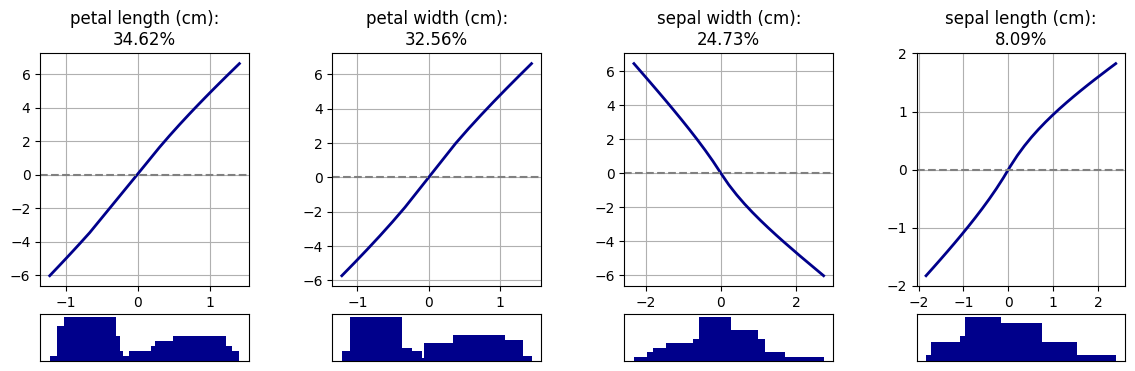

In [19]:
adapter.model.plot_single(show_n=5)

In [20]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, f1_score
from Dashboard.data_preprocessing import load_and_preprocess_data
from Dashboard.model_adapter import ModelAdapter
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, f1_score

X_train, X_test, y_train, y_test, task = load_and_preprocess_data("iris")
adapter = ModelAdapter(task)
adapter.fit(X_train, y_train)
y_train_pred = adapter.predict(X_train)
y_test_pred = adapter.predict(X_test)
if task == "regression":
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    print(f"MSE Train: {mse_train}, MSE Test: {mse_test}")
else:
    f1_train = f1_score(y_train, y_train_pred, average='weighted')
    f1_test = f1_score(y_test, y_test_pred, average='weighted')
    print(f"Train F1 Score: {f1_train}, Test F1 Score: {f1_test}")


features_to_change = ['sepal length (cm)', 'sepal width (cm)',  'petal length (cm)', 'petal width (cm)']
shape_functions_dict = adapter.model.get_shape_functions_as_dict()

# this part is already given in the flask application
feature_current_state = {}
for feature in shape_functions_dict:
    name = feature['name']
    y_value = feature['y']
    feature_current_state[name] = y_value

updated_data = {}

for feature in shape_functions_dict:
    name = feature['name']
    x_values = feature['x']
    print(name)
    if name in features_to_change:
        # Simulate user input (by setting negative values to 0); in flask app just use feature_current_state
        if feature["datatype"] == "categorical":
            #y_values = np.array(feature_current_state[name])
            updated_data[name] = {'x': x_values, 'y': np.array([-2]), 'datatype': 'categorical'}
        else:
            y_values = np.where(np.array(feature_current_state[name]) < 0, -0.2, feature_current_state[name])
            updated_data[name] = {'x': x_values, 'y': y_values.tolist(), 'datatype': 'numerical'}
    else:
        if feature['datatype'] == 'numerical':
            updated_data[name] = {'x': x_values, 'y': feature['y'].tolist(), 'datatype': 'numerical'}
        else:
            updated_data[name] = {'x': x_values, 'y': np.array([-0.5]), 'datatype': 'categorical'}
            #y_values = feature_current_state[name]
#spline, retrain_feature
adapter = adapter.adapt(features_to_change, updated_data, "spline", X_train, y_train)

<class 'numpy.ndarray'>
Train F1 Score: 1.0, Test F1 Score: 1.0
petal length (cm)
petal width (cm)
sepal length (cm)
sepal width (cm)
['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


Train F1 Score: 0.9874901960784314, Test F1 Score: 1.0


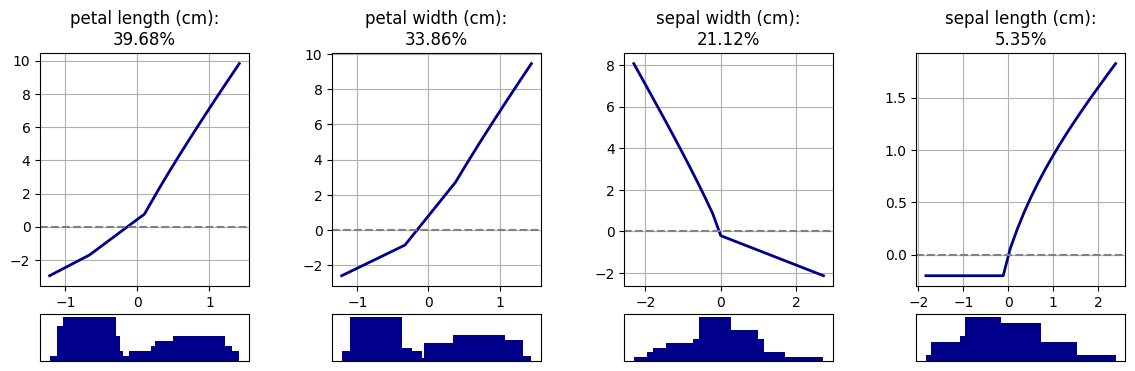

In [21]:
y_train_pred = adapter.predict(X_train)
y_test_pred = adapter.predict(X_test)
if task == "regression":
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    print(f"MSE Train: {mse_train}, MSE Test: {mse_test}")
else:
    f1_train = f1_score(y_train, y_train_pred, average='weighted')
    f1_test = f1_score(y_test, y_test_pred, average='weighted')
    print(f"Train F1 Score: {f1_train}, Test F1 Score: {f1_test}")

adapter.plot_single(show_n=5)

## Retrain Weights

In [30]:
X_train, X_test, y_train, y_test, task = load_and_preprocess_data()
adapter = ModelAdapter(task)
adapter.fit(X_train, y_train)


In [31]:
features_to_change = ['age', 'bmi', 'bp', 'sex']
shape_functions_dict = adapter.model.get_shape_functions_as_dict()

# this part is already given in the flask application
feature_current_state = {}
for feature in shape_functions_dict:
    name = feature['name']
    y_value = feature['y']
    feature_current_state[name] = y_value

updated_data = {}

for feature in shape_functions_dict:
    name = feature['name']
    x_values = feature['x']

    if name in features_to_change:
        # Simulate user input (by setting negative values to 0); in flask app just use feature_current_state
        if feature["datatype"] == "categorical":
            #y_values = np.array(feature_current_state[name])
            updated_data[name] = {'x': x_values, 'y': np.array([-2]), 'datatype': 'categorical'}
        else:
            y_values = np.where(np.array(feature_current_state[name]) < 0, -0.2, feature_current_state[name])
            updated_data[name] = {'x': x_values, 'y': y_values.tolist(), 'datatype': 'numerical'}

            #y_values = feature_current_state[name]

adapter = adapter.adapt(features_to_change, updated_data, "retrain_feature", X_train, y_train)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [23]:
y_train_pred = adapter.predict(X_train)
y_test_pred = adapter.predict(X_test)
if task == "regression":
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    print(f"MSE Train: {mse_train}, MSE Test: {mse_test}")
else:
    f1_train = f1_score(y_train, y_train_pred, average='weighted')
    f1_test = f1_score(y_test, y_test_pred, average='weighted')
    print(f"Train F1 Score: {f1_train}, Test F1 Score: {f1_test}")

MSE Train: 1.9934729974122902, MSE Test: 1.9651018934676747


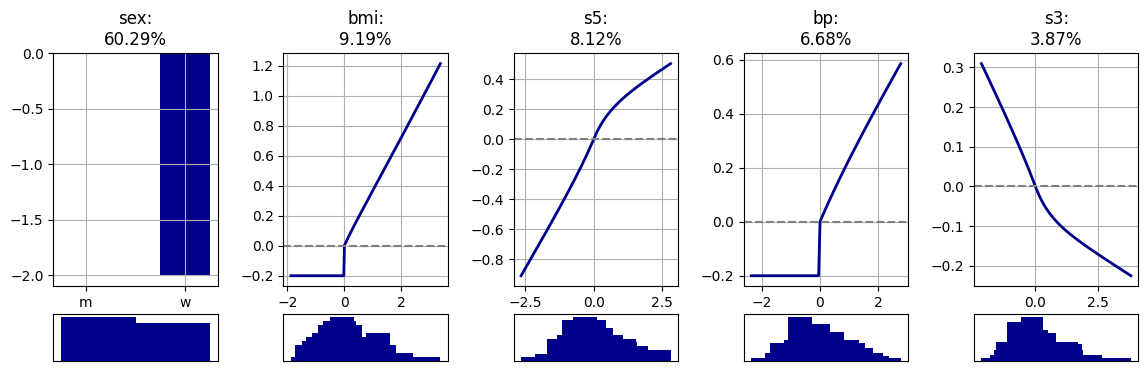

In [24]:
adapter.plot_single(show_n=5)
